# Step 1: Data Processing

In [1]:
#为整个建模工作提供数据处理与可视化能力
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm          

#用于构建ARCH / GARCH 模型，捕捉波动率聚集
from arch import arch_model           

#统计性描述、尾部分析、VaR分析等提供支持
from scipy import stats              
from scipy.stats import kurtosis 
from scipy.stats import rankdata

#时间序列预测模型（用于序列趋势建模）
from statsmodels.tsa.arima.model import ARIMA

#模型诊断
from statsmodels.stats.stattools import jarque_bera  #正态性检验，判断收益率是否符合正态分布
from statsmodels.stats.diagnostic import acorr_ljungbox #自相关检验，用于检验残差是否存在自相关或波动聚集

#提供进度条显示
from tqdm.notebook import tqdm
#忽略运行中的警告信息，保持输出清洁
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_9.csv',index_col = 'Date', parse_dates = True) #parse_dates:自动将日期字符串转换为 datetime 格式。
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,65.845001,66.687500,65.622498,66.254997,61.894112,8389600
2015-01-05,65.872498,65.875000,64.717499,64.792503,60.527866,12751200
2015-01-06,64.947502,65.195000,63.715000,64.375000,60.137852,11070000
2015-01-07,64.610001,65.285004,64.362503,65.237503,60.943584,9346800
2015-01-08,65.800003,66.279999,65.657501,66.112503,61.761002,10443200
2015-01-09,65.902496,66.117500,64.942497,65.132500,60.845497,10523600
2015-01-12,65.260002,65.500000,64.785004,65.004997,60.726372,6425600
2015-01-13,65.504997,66.452499,64.777496,65.195000,60.903870,10284000
2015-01-14,64.160004,64.650002,63.529999,63.889999,59.684761,12225200


In [3]:
# Knowing data type for all column
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [4]:
# Checking for missing value
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# Extract the Adjust Close price
p = df['Adj Close']
p

Date
2015-01-02     61.894112
2015-01-05     60.527866
2015-01-06     60.137852
2015-01-07     60.943584
2015-01-08     61.761002
                 ...    
2024-08-23    267.440002
2024-08-26    268.209991
2024-08-27    270.720001
2024-08-28    269.190002
2024-08-29    274.320007
Name: Adj Close, Length: 2431, dtype: float64

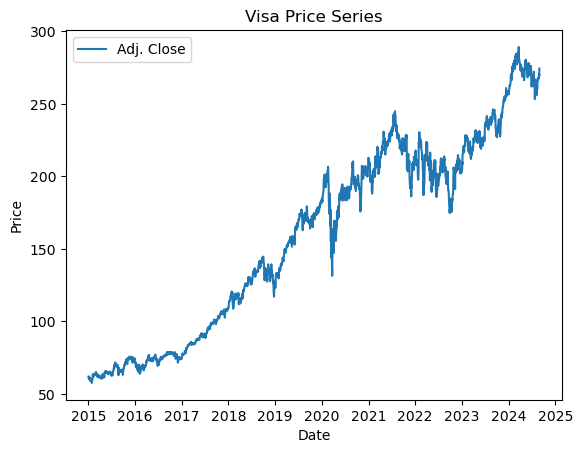

In [6]:
# plot of stock price checking for trends
plt.plot(p, label='Adj. Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Visa Price Series')
plt.legend()
plt.show()

#### **Conclusion**: The share price has a clear upward trend and a volatility clustering feature, so it can't be directly modeled.

In [7]:
# Log Return
r = np.log(p).diff() * 100
r

Date
2015-01-02         NaN
2015-01-05   -2.232119
2015-01-06   -0.646440
2015-01-07    1.330914
2015-01-08    1.332353
                ...   
2024-08-23   -0.186783
2024-08-26    0.287497
2024-08-27    0.931486
2024-08-28   -0.566762
2024-08-29    1.887788
Name: Adj Close, Length: 2431, dtype: float64

In [8]:
# Remove the day 1 return cuz missing
r = r[1:]   
print(r)
r.describe()

Date
2015-01-05   -2.232119
2015-01-06   -0.646440
2015-01-07    1.330914
2015-01-08    1.332353
2015-01-09   -1.493431
                ...   
2024-08-23   -0.186783
2024-08-26    0.287497
2024-08-27    0.931486
2024-08-28   -0.566762
2024-08-29    1.887788
Name: Adj Close, Length: 2430, dtype: float64


count    2430.000000
mean        0.061270
std         1.547585
min       -14.557135
25%        -0.655620
50%         0.135002
75%         0.828285
max        12.964701
Name: Adj Close, dtype: float64

In [9]:
# Calculate the quantile for the return serires
print(np.quantile(r, [0.001, 0.005, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.995, 0.999])) 

[-7.61010119 -5.08316035 -4.42861293 -1.52544177 -0.65562028  0.13500169
  0.82828529  1.59079591  4.21563545  5.30781029  9.77826039]


In [10]:
# Calculate the skewness and kurtosis
print(r.skew())
print(r.kurtosis())

-0.06978369607720848
9.730237658126462


#### **Conclusion**: 
- 相比正态分布，该资产的收益分布在两端尾部的概率更高
- 发生极端亏损或极端盈利的可能性高于正态分布的预测
- skew = -0.07, 轻微左偏，收益率略倾向负方向, 表示出现极端亏损的概率略高于极端上涨

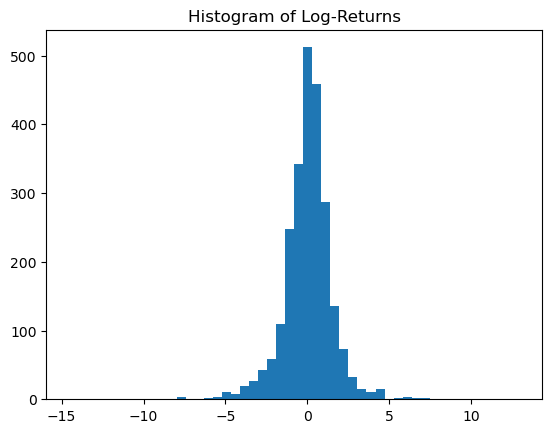

In [11]:
# Visualize the log return distribution
plt.hist(r, 50)
plt.title('Histogram of Log-Returns')
plt.show()

#### Conclusion:
- The distribution also has fat tails and high kurtosis, consistent with a kurtosis value of 9.74, which indicates a higher probability of extreme returns than predicted by a normal distribution.
- 不能使用正态分布VaR或OLS方差模型，应该使用 GARCH 或带厚尾分布的模型（t-GARCH、Historical VaR）

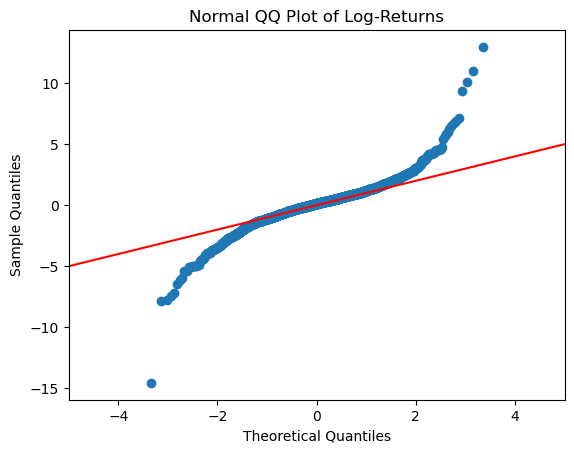

In [12]:
# 判断收益率分布是否符合正态分布假设
sm.qqplot(r, line='45')
plt.title('Normal QQ Plot of Log-Returns')
plt.xlim(-5, 5)
plt.show()

#### **Conclusion**： 
- QQ plot：帮助我们可视化判断是否对数回报符合正态分布。
- 左尾数据远低于红线下方，右尾数据远高于红线上方，意味着极端涨跌出现的概率远高于正态分布预测。
- 大部分中间的数据贴近于红线，说明收益率小幅波动时接近与正态分布。

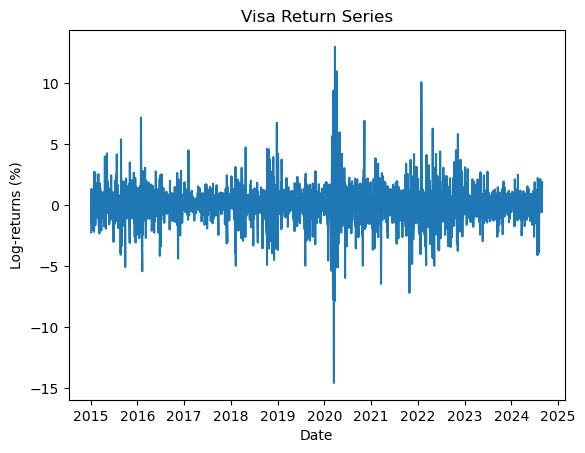

In [13]:
# 可视化对数回报的波动
plt.plot(r)
plt.xlabel('Date')
plt.ylabel('Log-returns (%)')
plt.title('Visa Return Series')
plt.show()

#### **Conclusion:**
- 大部分波动围绕在 0 附近。
- 有一些时期 （ex: 2020）疫情期间呈现连续的高波动, 涨跌幅极大,紧随其后的高波动时期；而其他阶段（ex：2016–2018）则相对平稳。
- 有几处收益率突破 ±10%（如 -15%、+12%）也就是非正态异常值存在。

### Extreme tails

In [14]:
# 比较标准化后的log return、Normal Distribution和 T distribution 的极端尾部分析
r_vec = r.values
r_std = (r_vec - np.mean(r_vec)) / np.std(r_vec)

print(f'The 0.1% quantile of actual standard return is: {np.quantile(r_std, 0.001).round(2)}') 
print(f'The 0.1% quantile of Normal distribution return is: {stats.norm.ppf(0.001).round(2)}')
print(f'The 0.1% quantile of T distribution return is: {stats.t.ppf(0.001, df=6).round(2)}')
print ('--------------')
print(f'The 99.9% quantile of actual standard return is: {np.quantile(r_std, 0.999).round(2)}')
print(f'The 99.9% quantile of Normal distribution return is: {stats.norm.ppf(0.999).round(2)}')
print(f'The 99.9% quantile of T distribution return is: {stats.t.ppf(0.999, df=8).round(2)}')

The 0.1% quantile of actual standard return is: -4.96
The 0.1% quantile of Normal distribution return is: -3.09
The 0.1% quantile of T distribution return is: -5.21
--------------
The 99.9% quantile of actual standard return is: 6.28
The 99.9% quantile of Normal distribution return is: 3.09
The 99.9% quantile of T distribution return is: 4.5


#### Conclusion:
- The actual data shows far heavier tails than the normal distribution, and even exceeds the tails of t-distributions with moderate degrees of freedom

### Augmented Dickey-Fuller Test用于判断时间序列是否平稳（是否有单位根） 

| 项目                | 解释                           | 我的结果        | 结论                    |
| ----------------- | ---------------------------- | ----------- | --------------------- |
| **ADF Statistic** | 越小越支持拒绝单位根原假设（即支持平稳性）        | -13.43      | 非常小，强烈拒绝非平稳性假设        |
| **p-value**       | 显著性检验指标，若 <0.05 则序列平稳        | 3.99e-25    | 显著拒绝原假设              |
| **滞后阶数**          | 模型自动选定的AR滞后期数                | 15          | 可用于进一步建模中参考           |
| **样本数**           | 有效样本量                        | 2414        | 数据量足够                 |
| **临界值**           | 用于与 ADF Statistic 比较，参考显著性水平 | -3.433（1%）等 | ADF Statistic < 所有临界值 |
| **IC 最优值**        | 最小AIC或BIC的值，仅用于模型比较          | 8831.7      | 可忽略不看                 |


In [18]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(r)

print('ADF Statistic:', adf_result[0].round(2))
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

if adf_result[1] < 0.05:
    print("The returns series is stationary.")
else:
    print("The returns series is non-stationary.")

ADF Statistic: -13.43
p-value: 3.9984273503122893e-25
Critical Values: {'1%': np.float64(-3.4330617925579685), '5%': np.float64(-2.8627380367880577), '10%': np.float64(-2.567407764552126)}
The returns series is stationary.


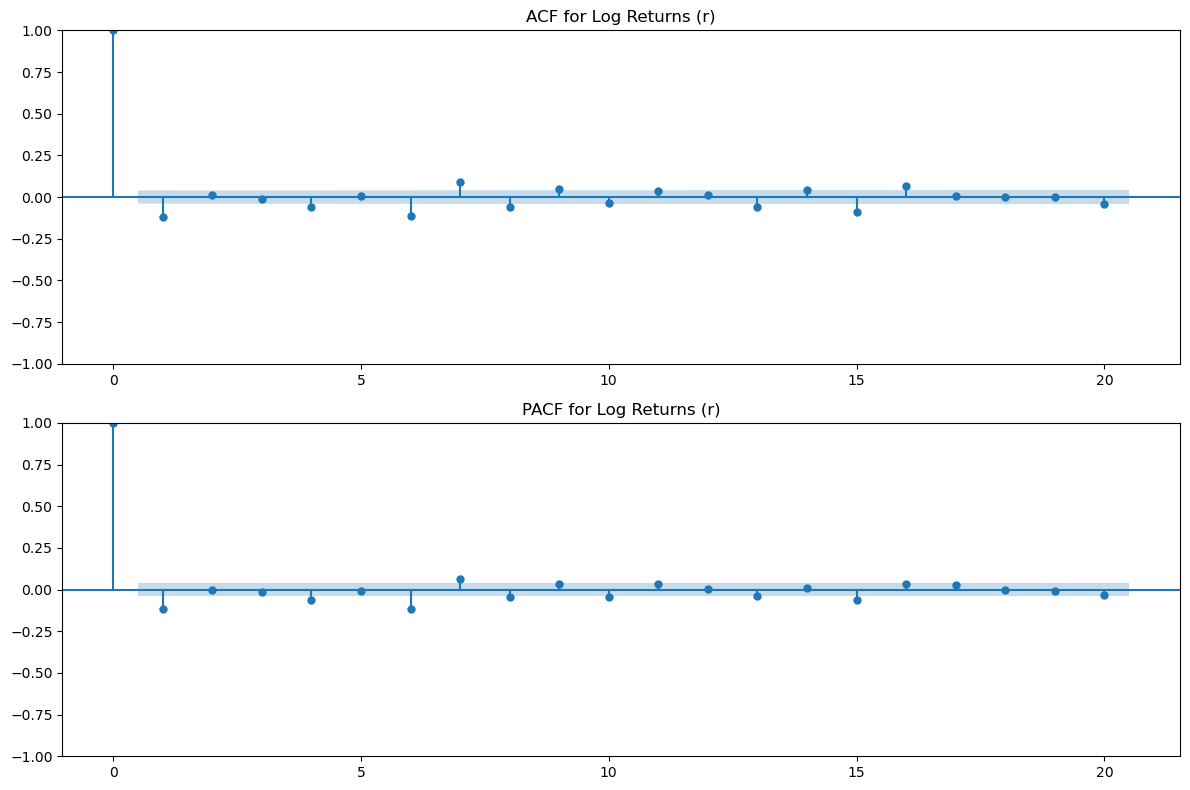

In [19]:
# ACF（自相关函数）和 PACF（偏自相关函数）分析
fig, ax = plt.subplots(2, figsize=(12,8))

sm.graphics.tsa.plot_acf(r.dropna(), lags=20, ax=ax[0]) #
ax[0].set_title('ACF for Log Returns (r)')

sm.graphics.tsa.plot_pacf(r.dropna(), lags=20, ax=ax[1])
ax[1].set_title('PACF for Log Returns (r)')

plt.tight_layout()
plt.show()

#### ACF:
- 检查序列整体的相关性，有助于判断是否有 MA 成分或残差序列是否白噪声
- ACF 的前一两个滞后期可能稍有显著性但都很小，其余基本都在置信区间内。说明收益率本身几乎没有显著自相关，没有明显的趋势或 AR/MA结构
- 对于金融数据来说，这是很常见的现象。价格不可预测，收益率近似白噪声

#### PACF：
- 显示的是每个滞后期在剔除前面滞后影响后的净影响，有助于判断是否有AR成分（自回归结构）
- Lag 1 非常显著，值接近 1.0, 可以考虑 AR(1) 结构
- 从 Lag 2 及以后 都落在置信区间内，偏相关不显著；高阶 AR 成分不重要，不建议使用 AR(2)+

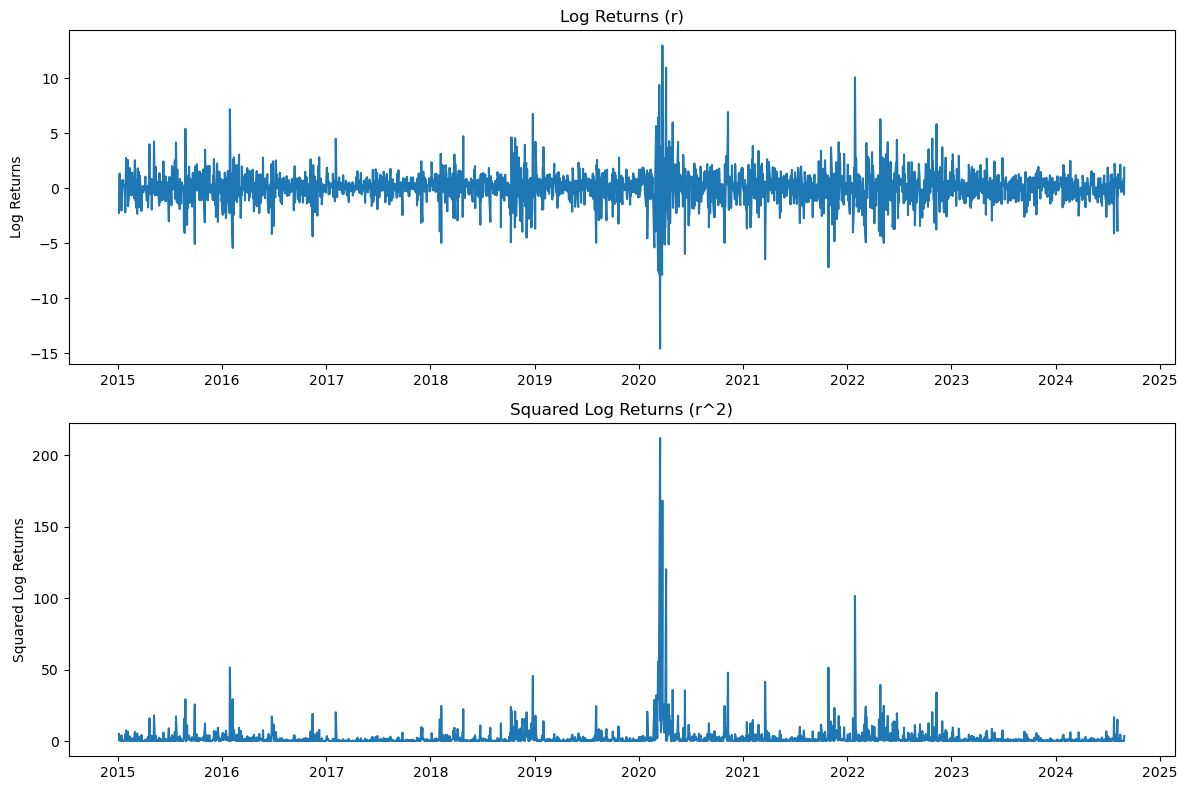

In [20]:
# Plot log returns and squared returns to check for volatility clustering
fig, ax = plt.subplots(2, figsize=(12,8))

ax[0].plot( r, label='Log Returns (r)')
ax[0].set_title('Log Returns (r)')
ax[0].set_ylabel('Log Returns')

ax[1].plot(r**2, label='Squared Log Returns (Volatility Clustering)')
ax[1].set_title('Squared Log Returns (r^2)')
ax[1].set_ylabel('Squared Log Returns')

plt.tight_layout()
plt.show()

#### Conclusion: 
- 对数收益的平方可以用来近似衡量波动率的大小
- 波动率存在显著的自相关性，说明它不是随机变化的，而是具有记忆性

In [ ]:
#检验序列中是否存在自相关性
print( "Ljung-Box Q-statistic:" )
for p in [ 5, 10, 15 ]:
    LB_test = acorr_ljungbox( r, lags=[p], return_df = False )
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, float(LB_test.iloc[0,0]), float(LB_test.iloc[0,1]) ) )
print()     

print( "Ljung-Box Q-statistic:" )
for p in [ 5, 10, 15 ]:
    LB_test = acorr_ljungbox( r**2, lags=[p], return_df = False )
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, float(LB_test.iloc[0,0]), float(LB_test.iloc[0,1]) ) )
print()   

#### Conclusion: 
- The Ljung-Box test strongly rejects the null hypothesis of no autocorrelation in the squared log returns.
- There is strong evidence in favour of conditional heteroskedasticity.

# Step 2: Model Building

### 1) Finding a return model

In [ ]:
acfplot = sm.graphics.tsa.plot_acf(r)
pacfplot = sm.graphics.tsa.plot_pacf(r)

- The ACF and PACF plots of the log returns indicate that the returns themselves exhibit weak or no autocorrelation, suggesting that the series is approximately white noise.
- I chose AR(6) based on the PACF plot, which showed significant partial autocorrelation up to lag 6 and then cut off. This suggested an AR(6) model would sufficiently capture the autocorrelation structure in the return series.

## AR(6)

In [ ]:
# Fit AR(6)
r_AR6 = ARIMA(r, order=(6, 0, 0)).fit() 
r_AR6.summary()

In [ ]:
print ('Ljung-Box Q-Statistic on Residual:')
for p in [p+5, p+10, p+15]:
    Qstat, pValue = acorr_ljungbox(r_AR6.resid, lags=[p], return_df=False).values[0]
    print('maxlag:{0:d}. Q-stat: {1:f}. P-value: {2:f}'.format(p, Qstat, pValue))

### Step 2: Finding a volatility model

Now I will assume an AR(6) model for the mean, and test the following models for conditional heteroskedasticy。


In [ ]:
ret = r.dropna()

p_range = range(1, 10)  # GARCH 里面的 p（滞后条件方差项的阶数）
q_range = range(1, 10)  # ARCH 里面的 q（滞后误差项的阶数）

best_aic = np.inf
best_pq = (0, 0)

for p in p_range:
    for q in q_range:
        try:
            res = arch_model(ret, mean='AR', lags=15, vol='GARCH', p=p, q=q).fit(disp="off")
 
            print(f"p={p}, q={q}, AIC={res.aic}")

            if res.aic < best_aic:
                best_aic = res.aic
                best_pq = (p, q)
        except Exception as e:
            print(f"Error for p={p}, q={q}: {e}")

print(f"Optimal p, q: {best_pq} with AIC: {best_aic}")

## Step3: Finding a distribution

#### 什么是 AIC 和 BIC？

| 指标      | 全称                             | 目的                      | 数学形式                  | 越小越好吗？ |
| ------- | ------------------------------ | ----------------------- | --------------------- | ------ |
| **AIC** | Akaike Information Criterion   | 衡量模型**拟合能力与复杂度的综合表现**   | AIC = 2k − 2ln(L)     |  越小越好 |
| **BIC** | Bayesian Information Criterion | 类似 AIC，但对**模型复杂度惩罚更严厉** | BIC = ln(n)k − 2ln(L) |  越小越好 |


In [ ]:
# Using Student T Distribution
res_AR6_GARCH37_t = arch_model(r, mean='AR',lags=6, vol='GARCH',p=3,q=7,dist='StudentsT').fit(disp="off")
res_AR6_GARCH37_t.summary()

In [ ]:
# Using Normal Distribution
res_AR6_GARCH37_n = arch_model(r, mean='AR',lags=6, vol='GARCH',p=3,q=7,dist='Normal').fit(disp="off")
res_AR6_GARCH37_n.summary()

In [ ]:
pd.DataFrame([[res_AR6_GARCH37_n.aic,res_AR6_GARCH37_t.aic],
               [res_AR6_GARCH37_n.bic,res_AR6_GARCH37_t.bic]],
             index = ['AIC', 'BIC'],
             columns = ['Gaussian', 'StudentT']).round(1)

AIC 和 BIC 的数值在学生T分布下都比较小，所以选择它

In [ ]:
# 检验模型 with Normal distribution的标准化残差是否服从正态分布

stdresid_normal = res_AR6_GARCH37_n.std_resid.dropna()
qq_norm = sm.qqplot(stdresid_normal,line='45') #将残差的分位数与标准正态分布进行比较
jb_norm = jarque_bera(stdresid_normal) #Jarque-Bera Test检查标准化残差是否服从正态分布
print(jb_norm)

#### Conclusion: 
- JB statistic（841.92）很大
- p-value 非常小（1.5e-183) < 0.05
- 拒绝原假设（H₀: 残差服从正态分布）
- 模型残差不服从正态，可能存在厚尾或偏态

In [ ]:
# 检验模型 with Student T distribution 的标准化残差是否服从正态分布

df = res_AR6_GARCH37_t.params['nu']  #获取该 t 分布的自由度
stdresid_t = res_AR6_GARCH37_t.std_resid.dropna() #提取 Student-t 分布 GARCH 模型的标准化残差

#将 t 分布标准化 使其具有单位方差
stdresid_t_unif = stats.t.cdf(np.sqrt(df / (df - 2)) * stdresid_t, df) 
stdresid_t_trans = stats.norm.ppf(stdresid_t_unif) #将上面均匀分布变量反向变换为标准正态分布
qq_t = sm.qqplot(stdresid_t_trans,line='45')

In [ ]:
jb_t = jarque_bera(stdresid_t_trans)
print(jb_t)

#### Conclusion: 
- Student-t 模型虽然比 Gaussian 好，但它仍未能完美拟合残差的正态性
- 确定残差不是正态分布

# Step 3: Rolling Expanding Window Forecast
- 用一段历史数据训练模型，预测“下一天”，然后窗口向前滚动一格，重复这个过程
- 用历史滑动窗口不断预测“下一天”，模拟真实预测，评估模型是否稳定有效的方法
- 对每一天都用过去的数据训练模型，并预测 未来一天的均值、标准差、VaR 和 ES

#### 1) 滑动窗口初始化

In [ ]:
# Total 
number_all = len (r)

# Number of forecast windows
number_wind = 500

# Size of each window
size_wind = number_all - number_wind

#### 2) 定义VaR and ES

In [ ]:
# Normal VaR
def qn(p):
    return stats.norm.ppf(p)  #正态分布的分位函数

# Normal Expected Shortfall 
def esn(p):
    ninv = stats.norm.ppf(p)
    return - stats.norm.pdf(ninv)/p

# StudentsT VaR
def qt(p,df):
    return stats.t.ppf(p,df) * np.sqrt((df - 2) / df)
                        
# StudentsT ES
def est(p,df):
    tinv = stats.t.ppf(p,df)
    f = lambda x: stats.t.pdf(x,df)
    return -f(tinv) / p * (df + tinv **2) / (df - 1) * np.sqrt((df-2)/df)

## **1-step ahead Forecast**

In [ ]:
# ARCH(1)-N
farch_mean = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
farch_sd = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
farch_var1 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
farch_var25 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
farch_es1 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
farch_es25 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')

# AR(6)-GARCH(3,7)-T 
fgarch_mean = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
fgarch_sd = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
fgarch_var1 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
fgarch_var25 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
fgarch_es1 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
fgarch_es25 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')

# Store the value of degree of freedom as we use t-distribution 
fgarch_df = pd.Series(index = r[-number_wind:].index, dtype = 'float64')

# Expanding Window Forecasting 
for i in tqdm(range(number_wind)): 
    train = r[:(size_wind+i+1)]

    #ARCH(1)-N 
    res_ARCH1_n = arch_model(train, mean = 'Constant', vol = 'ARCH', p=1, q=0, dist='Normal').fit(disp='off')  #Training part
    fc_ARCH1_n = res_ARCH1_n.forecast(horizon = 1, reindex = False)    # Forecast part
    
    # Result 
    mean = fc_ARCH1_n.mean
    sd = np.sqrt(fc_ARCH1_n.variance)

    var1 = -(mean + sd *qn(0.01))
    var25 = -(mean + sd *qn(0.025))
    es1= -(mean + sd *esn(0.01))
    es25 = -(mean + sd *esn(0.025))

    # Storge 
    farch_mean[i] = mean.iloc[0,0]
    farch_sd[i] = sd.iloc[0,0]
    farch_var1[i] = var1.iloc[0,0]
    farch_var25[i] = var25.iloc[0,0]
    farch_es1[i] = es1.iloc[0,0]
    farch_es25[i] = es25.iloc[0,0]

    
    # AR(6)-GARCH(3,7)-T
    res_AR6_GARCH37_t = arch_model(train, mean = 'AR', lags = 6, vol = 'GARCH', p=3, q=7, dist='StudentsT').fit(disp='off')
    fc_AR6_GARCH37_t = res_AR6_GARCH37_t.forecast(horizon = 1, reindex = False)  
 
    # Result 
    mean = fc_AR6_GARCH37_t.mean
    sd = np.sqrt(fc_AR6_GARCH37_t.variance)
    df = res_AR6_GARCH37_t.params['nu']
    
    var1 = -(mean + sd * qt(0.01, df))
    var25 = -(mean + sd * qt(0.025, df))
    es1= -(mean + sd *est(0.01, df))
    es25 = -(mean + sd *est(0.025, df))

    # Storge 
    fgarch_mean[i] = mean.iloc[0,0]
    fgarch_sd[i] = sd.iloc[0,0]
    fgarch_var1[i] = var1.iloc[0,0]
    fgarch_var25[i] = var25.iloc[0,0]
    fgarch_es1[i] = es1.iloc[0,0]
    fgarch_es25[i] = es25.iloc[0,0]

    fgarch_df[i] = df

#### 模型需要用到未来残差（residuals）和波动率，而这些是未知的

## **10-step Ahead Forecast**

In [ ]:
# ARCH(1)-N 
farch_mean_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
farch_sd_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
farch_var1_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
farch_var25_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
farch_es1_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
farch_es25_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')

# AR(8)-GARCH(3,7)-T
fgarch_mean_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
fgarch_sd_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
fgarch_var1_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
fgarch_var25_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
fgarch_es1_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
fgarch_es25_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')

# store the value of degree of freedom as we use t-distribution 
fgarch_df_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')


# 模拟的次数
B = 10000

# Expanding Window Forecasting
for i in tqdm(range(number_wind-9)): 
    train = r[:(size_wind+i+1)]

    #ARCH(1)-n
    res_ARCH1_n = arch_model(train, mean = 'Constant', vol = 'ARCH', p=1, q=0, dist='Normal').fit(disp='off')
    fc_ARCH1_n = res_ARCH1_n.forecast(horizon = 10, method = 'simulation', simulations = B, reindex = False)
    
    # Result 
    mean = fc_ARCH1_n.mean[['h.10']]
    sd = np.sqrt(fc_ARCH1_n.variance[['h.10']])

    simvals = fc_ARCH1_n.simulations.values[0,:,9]
    var1 = - np.quantile(simvals, 0.01)
    var25 = - np.quantile(simvals, 0.025)
    es1= - np.mean(simvals[(simvals<=-var1)])
    es25 = - np.mean(simvals[(simvals<=-var25)])

    # Storge 
    farch_mean_h10[i] = mean.iloc[0,0]
    farch_sd_h10[i] = sd.iloc[0,0]
    farch_var1_h10[i] = var1
    farch_var25_h10[i] = var25
    farch_es1_h10[i] = es1
    farch_es25_h10[i] = es25

    # AR(6)-GARCH(3,7)-t
    res_AR6_GARCH37_t = arch_model(train, mean = 'AR', lags = 6, vol = 'GARCH', p=3, q=7, dist='StudentsT').fit(disp='off')
    fc_AR6_GARCH37_t = res_AR6_GARCH37_t.forecast(horizon = 10, method = 'simulation', simulations = B, reindex = False)
    
    # Result - Sampling from the uncertain distribution and based on the samples to calculate 
    mean = fc_AR6_GARCH37_t.mean[['h.10']]
    sd = np.sqrt(fc_AR6_GARCH37_t.variance[['h.10']])
    df = res_AR6_GARCH37_t.params['nu']

    simvals = fc_AR6_GARCH37_t.simulations.values[0,:,9] # 
    var1 = - np.quantile(simvals, 0.01)
    var25 = - np.quantile(simvals, 0.025)
    es1= - np.mean(simvals[(simvals<=-var1)])
    es25 = - np.mean(simvals[(simvals<=-var25)])

    # Storge 
    fgarch_mean_h10[i] = mean.iloc[0,0]
    fgarch_sd_h10[i] = sd.iloc[0,0]
    fgarch_var1_h10[i] = var1
    fgarch_var25_h10[i] = var25
    fgarch_es1_h10[i] = es1
    fgarch_es25_h10[i] = es25

    fgarch_df_h10[i] = df

## **22-step Ahead Forecast**

In [ ]:
# ARCH(1)- N
farch_mean_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
farch_sd_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
farch_var1_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
farch_var25_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
farch_es1_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
farch_es25_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')

# AR(6)-GARCH(3,7)- T
fgarch_mean_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
fgarch_sd_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
fgarch_var1_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
fgarch_var25_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
fgarch_es1_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
fgarch_es25_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
# store the value of degree of freedom as we use t-distribution 
fgarch_df_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')

# 模拟次数
B = 10000

# Expanding Window
for i in tqdm(range(number_wind-21)): 
    train = r[:(size_wind+i+1)]

    #ARCH(1)-n
    res_ARCH1_n = arch_model(train, mean = 'Constant', vol = 'ARCH', p=1, q=0, dist='Normal').fit(disp='off')
    fc_ARCH1_n = res_ARCH1_n.forecast(horizon = 22, method = 'simulation', simulations = B, reindex = False)
    
    # Result 
    mean = fc_ARCH1_n.mean[['h.22']]
    sd = np.sqrt(fc_ARCH1_n.variance[['h.22']])

    simvals = fc_ARCH1_n.simulations.values[0,:,21]
    var1 = - np.quantile(simvals, 0.01)
    var25 = - np.quantile(simvals, 0.025)
    es1= - np.mean(simvals[(simvals<=-var1)])
    es25 = - np.mean(simvals[(simvals<=-var25)])

    # Storge 
    farch_mean_h22[i] = mean.iloc[0,0]
    farch_sd_h22[i] = sd.iloc[0,0]
    farch_var1_h22[i] = var1
    farch_var25_h22[i] = var25
    farch_es1_h22[i] = es1
    farch_es25_h22[i] = es25
    
    # AR(6)-GARCH(3,7)-t
    res_AR6_GARCH37_t = arch_model(train, mean = 'AR', lags = 6, vol = 'GARCH', p=3, q=7, dist='StudentsT').fit(disp='off')
    fc_AR6_GARCH37_t = res_AR6_GARCH37_t.forecast(horizon = 22, method = 'simulation', simulations = B, reindex = False)
    
    # Result 
    mean = fc_AR6_GARCH37_t.mean[['h.22']]
    sd = np.sqrt(fc_AR6_GARCH37_t.variance[['h.22']])
    df = res_AR6_GARCH37_t.params['nu']

    simvals = fc_AR6_GARCH37_t.simulations.values[0,:,21]
    var1 = - np.quantile(simvals, 0.01)
    var25 = - np.quantile(simvals, 0.025)
    es1= - np.mean(simvals[(simvals<=-var1)])
    es25 = - np.mean(simvals[(simvals<=-var25)])

    # Storge 
    fgarch_mean_h22[i] = mean.iloc[0,0]
    fgarch_sd_h22[i] = sd.iloc[0,0]
    fgarch_var1_h22[i] = var1
    fgarch_var25_h22[i] = var25
    fgarch_es1_h22[i] = es1
    fgarch_es25_h22[i] = es25

    fgarch_df_h22[i] = df

# Step 4: Validation
- 模型预测性能评估（预测值 vs 实际值）

In [ ]:
# h = 1 
y_val = r[-500:]

# plot 
plt.figure(figsize = (16,10))
plt.plot(farch_mean, label = 'ARCH-n')
plt.plot(fgarch_mean, label = 'AR-GARCH-t')
plt.plot(y_val, label = 'Log Returns')
plt.title('Model Forecasts', fontsize=20)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.show()

# RMSE
rmse_arch_mean = np.sqrt(np.mean((y_val-farch_mean)**2))
rmse_garch_mean = np.sqrt(np.mean((y_val-fgarch_mean)**2))

In [ ]:
# h = 10 
y_val = r[-491:]

# RMSE
rmse_arch_mean_h10 = np.sqrt(np.mean((y_val-farch_mean_h10)**2))
rmse_garch_mean_h10 = np.sqrt(np.mean((y_val-fgarch_mean_h10)**2))

# h = 22
y_val = r[-479:]

# RMSE
rmse_arch_mean_h22 = np.sqrt(np.mean((y_val-farch_mean_h22)**2))
rmse_garch_mean_h22 = np.sqrt(np.mean((y_val-fgarch_mean_h22)**2))

In [ ]:
mdl_name = ['ARCH-n','AR-GARCH-t']
horizon = [1,10,22]
rmse = [[rmse_arch_mean,rmse_garch_mean],
        [rmse_arch_mean_h10,rmse_garch_mean_h10],
        [rmse_arch_mean_h22,rmse_garch_mean_h22],]
tbl_rmse_mean = pd.DataFrame(rmse, index = horizon, columns = mdl_name)
tbl_rmse_mean.index.name = 'Horizon'
tbl_rmse_mean.round(4)

# Step 5: Calculate VaR

In [ ]:
#用于判断模型的超出次数是否符合理论VaR水平
def uctest (viol, a):
    n = len(viol)
    p = np.sum(viol) / n
    z = (p-a) / np.sqrt(a*(1-a)/n)
    pval = 2 * stats.norm.sf(np.abs(z))
    return pval, p 

#检测 VaR 超出是否是随机分布的 即有没有连续爆雷
def indtest (viol):
    try:
        n = len(viol)

        r5 = viol[1:]
        r51 = viol[:-1]
        i11 = r5*r51
        i01 = r5*(1-r51)
        i10=(1-r5)*r51
        i00 = (1-r5)*(1-r51)

        t00 = np.sum(i00)
        t01 = np.sum(i01)
        t10 = np.sum(i10)
        t11 = np.sum(i11)
        p01 = t01 / (t00+t01)
        p11 = t11 / (t10+t11)
        p1 = (t01+t11)/n 
        ll1 = t00 * np.log(1-p01) + (p01>0)*t01*np.log(p01)+t10*np.log(1-p11)
        if p11 > 0:
            ll1 = ll1 + t11 * np.log(p11)
        
        ll0 = (t10+t00)*np.log(1-p1)+(t01+t11)*np.log(p1)
        lrid=2*(ll1 - ll0)
        pcc = 1-stats.chi2.cdf(lrid,1)
    except:
        pcc = np.nan
        lrid = np.nan
    return pcc, lrid

# 模型是否能及时更新VaR水平来反应市场变化
def dqtest(y, var, a, lag):
    n = len(y)
    hits = ((-y > var) * 1)  
    q = 2 + lag

    if np.sum(hits) > 0:  
        ns = n - lag
        xmat = np.column_stack([np.ones((ns, 1)), var[lag:n]])
        for k in range(1, lag + 1):
            lk = lag - k
            xmat = np.column_stack([xmat, hits[lk:n-k]])

        hx = np.dot(hits[lag:], xmat)
        xtx = np.linalg.lstsq(np.matmul(xmat.T, xmat), np.eye(q), rcond=None)[0]
        
        
        dq = np.dot(hx, np.dot(xtx, hx.T))
        dq = dq / (a * (1 - a))  
        pdq = 1 - stats.chi2.cdf(dq, q)
    else:
        pdq = np.nan
        dq = np.nan
    return pdq, dq


# Pinball Loss Function 用于比较两个VaR模型在预测准确性上的综合表现
def qloss(q, r, p):
    q = - np.array(q)
    x1 = r[r > q]
    x2 = r[r < q]
    f1 = q[r > q]
    f2 = q[r < q]
    l = p * np.sum(x1-f1) + (1-p) * np.sum(f2-x2)
    return l

# Accuracy checks for VaR 
def check_var_fc(var_fc, r, p):
    viol = -r > var_fc  # 检查是否超出VaR
    n_viol = np.sum(viol) #统计爆雷次数
    pval_uc, p_hat = uctest(viol, p) #是否符合理论比例
    pval_ind = indtest(viol)[0] #是否随机爆雷
    pval_dq = dqtest(r, var_fc, p, 4)[0] #模型是否能随着市场波动动态调整VaR预测值
    qtl_loss = qloss(var_fc, r, p)  #计算 VaR 模型整体误差, 预测值离实际损失有多远
    return [n_viol, p_hat, pval_uc, pval_ind, pval_dq, qtl_loss]

## **1) 1-step ahead**  
- **1% VaR** 

In [ ]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-500:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_var1, 'r', label = 'ARCH') # negative sign just for revieing the graph 
plt.plot(-fgarch_var1, 'k', label = 'GARCH')

plt.title('1% VaR')
plt.legend()
plt.show()

In [ ]:
# violations 
plt.figure(figsize = (10, 6))
plt.plot(r[-500:],'m-', alpha = 0.2, label = 'Log Returns')

plt.plot(r[-500:][r[-500:] < -farch_var1],'^', mfc = 'none', label = 'ARCH-n')
plt.plot(r[-500:][r[-500:] < -farch_var1],'ko', mfc = 'none', label = 'AR-GARCH-t')

plt.legend()
plt.title('1% VaR violations')
plt.show()

##### Conclusion: Using 1% VaR, we can see nothing violated under the two models, which means that this risk management strategy is too conservative. The advantage of this conservative strategy is that it's not easy to have financial crisis, but the disadvantage is preparing too much cash for extreme events happened. 

In [ ]:
# Forecast accuracy checks 
tbl_var1 = pd.DataFrame({
    'ARCH-n': check_var_fc(farch_var1, r[-500:], 0.01),
    'AR-GARCH-t': check_var_fc(fgarch_var1, r[-500:],0.01)},
     index = ['Viol.(5)','$\hat{p}$', 'UC','Ind','DQ','Q Loss']).T
tbl_var1.insert(0, 'Horizon', [1,1])
tbl_var1.round(4)
    

##### Comment: Both models fail the unconditional coverage test(p-value < 0.05). If these VaR forecasts are used, too much cash will be held against risky assets that could better invested elsewhere. With no violation, independence and DQ test are useless, but based on the Q Loss, we can see that AR-GARCH model is smaller than ARCH model, which means it's better than ARCH.

## **2.5% VaR** 

In [ ]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-500:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_var25, 'r', label = 'ARCH') 
plt.plot(-fgarch_var25, 'k', label = 'GARCH')

plt.title('2.5% VaRs')
plt.legend()
plt.show()

In [ ]:
# VaR violations 
plt.figure(figsize = (10, 6))
plt.plot(r[-500:],'m-', alpha = 0.2, label = 'Log Returns')

plt.plot(r[-500:][r[-500:] < -farch_var25], 'v', color='blue', label='ARCH-n')  
plt.plot(r[-500:][r[-500:] < -fgarch_var25], 'o', color='green', label='AR-GARCH-t')


plt.legend()
plt.title('2.5% VaR violations')
plt.show()

#### 对冲会计中，也可以用类似结构。模型触发“对冲状态”，自动生成会计凭证模板 比如对冲准备金、FVTOCI项变动等

In [ ]:
# forecast accuracy checks 
tbl_var25 = pd.DataFrame({
    'ARCH-n': check_var_fc(farch_var25, r[-500:], 0.025),
    'AR-GARCH-t': check_var_fc(fgarch_var25, r[-500:],0.025)},
     index = ['Viol.(12.5)','$\hat{p}$', 'UC','Ind','DQ','Q Loss']).T
tbl_var25.insert(0, 'Horizon', [1,1])
tbl_var25.round(4)
    

##### The ARCH model with normal errors leads to VaR forecasts that have a low size 0 violations. It fails the unconditional coverage test (p - value < 0.05). If these VaR forcasts are used, too much cash will be held against risky assets that could better invested elsewhere. Additionally, the ARCH model doesn't pass the DQ test, suggesting that there is sufficient evidence to conclude that VaR forecasts are dependent. 

##### The AR-GARCH model with t errors also has a size 0.2% violations which is also significantly different from the target 5%. Besides, it doesn't pass the DQ test which indicates dependency of VaR forecasts, there is ten violations. 


## **2)10-step ahead**  
- 1% VaR 

In [ ]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-491:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_var1_h10, 'r', label = 'ARCH') # negative sign just for revieing the graph 
plt.plot(-fgarch_var1_h10, 'k', label = 'GARCH')

plt.title('1% VaR')
plt.legend()
plt.show()

In [ ]:
# violations 
plt.figure(figsize = (10, 6))
plt.plot(r[-491:],'m-', alpha = 0.2, label = 'Log Returns')

plt.plot(r[-491:][r[-491:] < -farch_var1_h10], 'v', color='blue', label='ARCH-n')  
plt.plot(r[-491:][r[-491:] < -fgarch_var1_h10], 'o', color='green', label='AR-GARCH-t')

plt.legend()
plt.title('1% VaR violations')
plt.show()

In [ ]:
# forecast accuracy checks 
tbl_var1_h10 = pd.DataFrame({
    'ARCH-n': check_var_fc(farch_var1_h10, r[-491:], 0.01),
    'AR-GARCH-t': check_var_fc(fgarch_var1_h10, r[-491:],0.01)},
     index = ['Viol.(5)','$\hat{p}$', 'UC','Ind','DQ','Q Loss']).T
tbl_var1_h10.insert(0, 'Horizon', [10,10])
tbl_var1_h10.round(4)

- 2.5% VaR

In [ ]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-491:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_var25_h10, 'r', label = 'ARCH') 
plt.plot(-fgarch_var25_h10, 'k', label = 'GARCH')

plt.title('2.5% VaRs')
plt.legend()
plt.show()

In [ ]:
# violations 
plt.figure(figsize = (10, 6))
plt.plot(r[-491:],'m-', alpha = 0.2, label = 'Log Returns')

plt.plot(r[-491:][r[-491:] < -farch_var25_h10], 'v', color='blue', label='ARCH-n')  
plt.plot(r[-491:][r[-491:] < -fgarch_var25_h10], 'o', color='green', label='AR-GARCH-t')

plt.legend()
plt.title('2.5% VaR violations')
plt.show()

In [ ]:
# forecast accuracy checks 
tbl_var25_h10 = pd.DataFrame({
    'ARCH-n': check_var_fc(farch_var25_h10, r[-491:], 0.025),
    'AR-GARCH-t': check_var_fc(fgarch_var25_h10, r[-491:],0.025)},
     index = ['Viol.(12.5)','$\hat{p}$', 'UC','Ind','DQ','Q Loss']).T
tbl_var25_h10.insert(0, 'Horizon', [10,10])
tbl_var25_h10.round(4)

## **3) 22-steps ahead**  
- 1% VaR 

In [ ]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-479:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_var1_h22, 'r', label = 'ARCH') 
plt.plot(-fgarch_var1_h22, 'k', label = 'GARCH')

plt.title('1% VaRs')
plt.legend()
plt.show()

In [ ]:
# violations 
plt.figure(figsize = (10, 6))
plt.plot(r[-479:],'m-', alpha = 0.2, label = 'Log Returns')

plt.plot(r[-479:][r[-479:] < -farch_var1_h22], 'v', color='blue', label='ARCH-n')  
plt.plot(r[-479:][r[-479:] < -fgarch_var1_h22], 'o', color='green', label='AR-GARCH-t')

plt.legend()
plt.title('1% VaR violations')
plt.show()

In [ ]:
# forecast accuracy checks 
tbl_var1_h22 = pd.DataFrame({
    'ARCH-n': check_var_fc(farch_var1_h22, r[-479:], 0.01),
    'AR-GARCH-t': check_var_fc(fgarch_var1_h22, r[-479:],0.01)},
     index = ['Viol.(5)','$\hat{p}$', 'UC','Ind','DQ','Q Loss']).T
tbl_var1_h22.insert(0, 'Horizon', [22,22])
tbl_var1_h22.round(4)
    

- 2.5% VaR 

In [ ]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-479:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_var25_h22, 'r', label = 'ARCH') 
plt.plot(-fgarch_var25_h22, 'k', label = 'GARCH')

plt.title('2.5% VaRs')
plt.legend()
plt.show()

In [ ]:
# violations 
plt.figure(figsize = (10, 6))
plt.plot(r[-479:],'m-', alpha = 0.2, label = 'Log Returns')

plt.plot(r[-479:][r[-479:] < -farch_var25_h22], 'v', color='blue', label='ARCH-n')  
plt.plot(r[-479:][r[-479:] < -fgarch_var25_h22], 'o', color='green', label='AR-GARCH-t')

plt.legend()
plt.title('2.5% VaR violations')
plt.show()

In [ ]:
# forecast accuracy checks 
tbl_var25_h22 = pd.DataFrame({
    'ARCH-n': check_var_fc(farch_var25_h22, r[-479:], 0.025),
    'AR-GARCH-t': check_var_fc(fgarch_var25_h22, r[-479:],0.025)},
     index = ['Viol.(12.5)','$\hat{p}$', 'UC','Ind','DQ','Q Loss']).T
tbl_var25_h22.insert(0, 'Horizon', [22,22])
tbl_var25_h22.round(4)

In [ ]:
# Summary for 1% VaR forecast

tbl_var1_all = pd.concat([tbl_var1, tbl_var1_h10,tbl_var1_h22])
tbl_var1_all.reset_index(names=['Module'], inplace=True)
tbl_var1_all = tbl_var1_all.groupby(['Horizon','Module']).mean()
tbl_var1_all.round(4)

In [ ]:
# Summary for 2.5% VaR forecast

tbl_var25_all = pd.concat([tbl_var25, tbl_var25_h10,tbl_var25_h22])
tbl_var25_all.reset_index(names=['Module'], inplace=True)
tbl_var25_all = tbl_var25_all.groupby(['Horizon','Module']).mean()
tbl_var25_all.round(4)

# Expected Shortfall (ES)

In [ ]:
def jointloss(es,q,r,p):
    m = len(r)
    q = np.array(q)
    es = np.array(es)
    i1 = (r<q).astype(int)
    aes = es** (-1)*(p-1)
    ees = (r-q) * (p-i1)
    l = -np.log(aes)-ees/es/p
    return l

## **1-step ahead**  
- 1% ES 

In [ ]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-500:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_es1, 'r', label = 'ARCH')  
plt.plot(-fgarch_es1, 'k', label = 'GARCH')

plt.title('1% ES')
plt.legend()
plt.show()

In [ ]:
fz_arch_1 = jointloss(-farch_es1, -farch_var1, r[-500:],0.01)
fz_garch_1 = jointloss(-farch_es1, -fgarch_var1, r[-500:],0.01)

print(np.mean(fz_arch_1))
print(np.mean(fz_garch_1))

##### Comment: The Fissler Ziegler loss for the GARCH model is slightly lower than the ARCH model, whic implies that the GARCH model is better for 1-day ahead 1% ES forecasting. 



## **2.5% ES** 

In [ ]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-500:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_es25, 'r', label = 'ARCH')  
plt.plot(-fgarch_es25, 'k', label = 'GARCH')

plt.title('2.5% ES')
plt.legend()
plt.show()

In [ ]:
fz_arch_25 = jointloss(-farch_es25, -farch_var25, r[-500:],0.025)
fz_garch_25 = jointloss(-farch_es25, -fgarch_var25, r[-500:],0.025)

print(np.mean(fz_arch_25))
print(np.mean(fz_garch_25))

##### Comment: In this case, the Fissler Ziegler loss for the GARCH model is still lower than the ARCH model, whic implies that the GARCH model is still better for 1-day ahead 5% ES forecasting. 

## **10-steps ahead**  


In [ ]:
# 1% ES 
fz_arch_1_h10 = jointloss(-farch_es1_h10, -farch_var1_h10, r[-491:],0.01)
fz_garch_1_h10 = jointloss(-farch_es1_h10, -fgarch_var1_h10, r[-491:],0.01)

print(np.mean(fz_arch_1_h10))
print(np.mean(fz_garch_1_h10))


# 2.5% ES 
fz_arch_25_h10 = jointloss(-farch_es25_h10, -farch_var25_h10, r[-491:],0.025)
fz_garch_25_h10 = jointloss(-farch_es25_h10, -fgarch_var25_h10, r[-491:],0.025)

print(np.mean(fz_arch_25_h10))
print(np.mean(fz_garch_25_h10))

## **22-steps ahead**  

In [ ]:
# 1% ES 
fz_arch_1_h22 = jointloss(-farch_es1_h22, -farch_var1_h22, r[-479:],0.01)
fz_garch_1_h22 = jointloss(-farch_es1_h22, -fgarch_var1_h22, r[-479:],0.01)

print(np.mean(fz_arch_1_h22))
print(np.mean(fz_garch_1_h22))


# 2.5% ES 
fz_arch_25_h22 = jointloss(-farch_es25_h22, -farch_var25_h22, r[-479:],0.025)
fz_garch_25_h22 = jointloss(-farch_es25_h22, -fgarch_var25_h22, r[-479:],0.025)

print(np.mean(fz_arch_25_h22))
print(np.mean(fz_garch_25_h22))